### EDA on labeled set of abstracts

covers initial set (1200) and updated set (1600) 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

import seaborn as sns

In [2]:
df = pd.read_pickle("../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.reset_index(inplace = True, drop = True)
df.shape

(1143869, 30)

In [3]:
df.dtypes

PROJECT_ID                     object
ABSTRACT                       object
PROJECT_TERMS                  object
PROJECT_TITLE                  object
DEPARTMENT                     object
AGENCY                         object
IC_CENTER                      object
PROJECT_NUMBER                 object
PROJECT_START_DATE             object
PROJECT_END_DATE               object
CONTACT_PI_PROJECT_LEADER      object
OTHER_PIS                      object
CONGRESSIONAL_DISTRICT         object
DUNS_NUMBER                    object
ORGANIZATION_NAME              object
ORGANIZATION_CITY              object
ORGANIZATION_STATE             object
ORGANIZATION_ZIP               object
ORGANIZATION_COUNTRY           object
BUDGET_START_DATE              object
BUDGET_END_DATE                object
CFDA_CODE                      object
FY                             object
FY_TOTAL_COST                 float64
FY_TOTAL_COST_SUB_PROJECTS    float64
ORG_COUNT                       int64
PI_COUNT    

In [4]:
df.head()

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


#### Initial labeled set - 1,200 abstracts

In [5]:
old_df = pd.read_csv('../../../data/prd/Digital_abstract_labelled/AUG-2022-labelled_abstracts.csv')
print(old_df.shape)

(1200, 8)


In [6]:
old_df.dtypes

Unnamed: 0                    int64
Duplicates                    int64
index                         int64
PROJECT_ID                    int64
ABSTRACT                     object
Is it related to Big-Data     int64
Expert name                  object
label                        object
dtype: object

In [7]:
old_df["PROJECT_ID"] = old_df["PROJECT_ID"].astype(str)
old_df = old_df.drop(columns=['Unnamed: 0'])

In [8]:
old_df.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [9]:
# merge agency and year information into training set 

d = old_df.merge(df[["PROJECT_ID", "DEPARTMENT", "FY"]], how = 'left', on = "PROJECT_ID")

In [10]:
d.shape

(1200, 9)

In [11]:
d.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,DEPARTMENT,FY
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data,HHS,2017
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data,HHS,2019
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data,HHS,2008
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data,HHS,2016
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data,HHS,2015


##### Agency, FY, label break downs

In [12]:
d["label"].value_counts()

Non Big-data    713
Big-data        487
Name: label, dtype: int64

In [13]:
100*d["label"].value_counts()/len(d)

Non Big-data    59.416667
Big-data        40.583333
Name: label, dtype: float64

In [14]:
agency_counts = d["DEPARTMENT"].value_counts()

Text(0.5, 1.0, 'Project Frequency by Funding Agency')

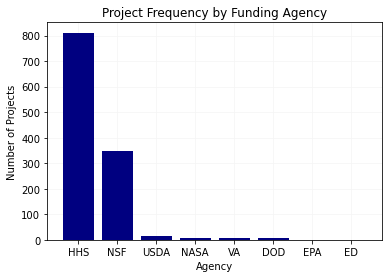

In [15]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
#plt.ylim(0,100)
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency")

#plt.savefig("figures/OECD/agency_dist.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("figures/OECD/agency_dist.pdf", dpi = 800, bbox_inches = "tight")

In [16]:
pd.pivot_table(d, values=['PROJECT_ID'], index=['DEPARTMENT'], columns=['label'], aggfunc='count', fill_value=0, margins = True)

PROJECT_ID                   
label        Big-data Non Big-data   All
DEPARTMENT                              
DOD                 2            6     8
ED                  0            1     1
EPA                 0            1     1
HHS               246          565   811
NASA                0            9     9
NSF               234          113   347
USDA                4           10    14
VA                  1            8     9
All               487          713  1200

<AxesSubplot:xlabel='DEPARTMENT', ylabel='count'>

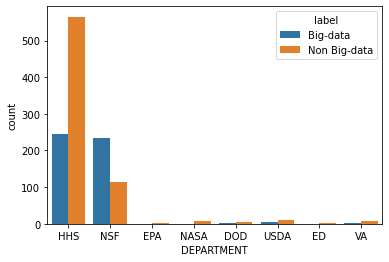

In [17]:
sns.countplot(data=d, x='DEPARTMENT', hue='label')

#g.set_axis_labels("", "Body mass (g)")
#g.legend.set_title("")

In [18]:
year_counts = d["FY"].value_counts().sort_index(ascending=True)

<ipython-input-19-29184aefaed3>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0.5, 1.0, 'Project Frequency by FY')

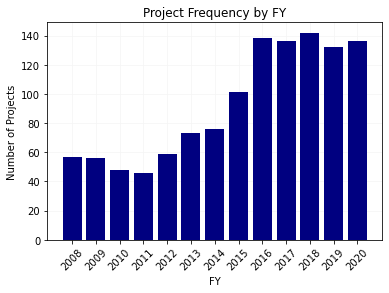

In [19]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
#plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by FY")

#plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [20]:
pd.pivot_table(d, values=['PROJECT_ID'], index=['FY'], columns=['label'], aggfunc='count', fill_value=0, margins = True)

PROJECT_ID                   
label   Big-data Non Big-data   All
FY                                 
2008           5           52    57
2009           3           53    56
2010           2           46    48
2011           4           42    46
2012          12           47    59
2013          26           47    73
2014          30           46    76
2015          51           50   101
2016          78           60   138
2017          75           61   136
2018          76           66   142
2019          65           67   132
2020          60           76   136
All          487          713  1200

<AxesSubplot:xlabel='FY', ylabel='count'>

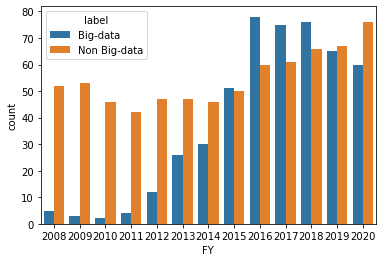

In [21]:
sns.countplot(data=d, x='FY', hue='label', order=d["FY"].value_counts().sort_index(ascending=True).index)

##### Compare labels with term matching on "big data"

In [22]:
# cross check training set with term matching for "big data"

d["big data term"] = False

In [23]:
d.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,DEPARTMENT,FY,big data term
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data,HHS,2017,False
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data,HHS,2019,False
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data,HHS,2008,False
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data,HHS,2016,False
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data,HHS,2015,False


In [24]:
for idx, abstract in enumerate(d['ABSTRACT']):
    if "big data" in abstract.lower() or "big-data" in abstract.lower():
        d.iloc[idx, 9] = True

In [25]:
sum(d['big data term'])

595

In [26]:
pd.pivot_table(d, values=['PROJECT_ID'], index=['big data term'], columns=['label'], aggfunc='count', fill_value=0, margins=True)

PROJECT_ID                   
label           Big-data Non Big-data   All
big data term                              
False                 45          560   605
True                 442          153   595
All                  487          713  1200

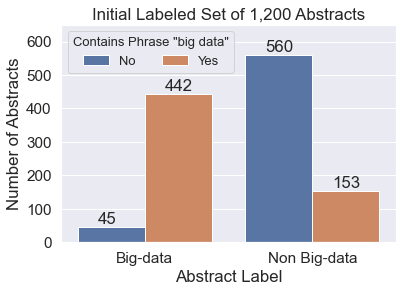

In [125]:
sns.set(font_scale=1.4)
ax = sns.countplot(data=d, x='label', hue='big data term')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.12, p.get_height()+10))
plt.ylim(0,650)
    
plt.title("Initial Labeled Set of 1,200 Abstracts")
plt.xlabel("Abstract Label")
plt.ylabel("Number of Abstracts")
plt.legend(title='Contains Phrase "big data"', loc='upper left', ncol=2, labels=['No', 'Yes'], 
          title_fontsize=13, fontsize=13) #bbox_to_anchor=(0.80, -0.2))

plt.savefig("figures/init_label_term.png", bbox_inches = "tight")

#### Updated Labeled Set - 1,600 abstracts

In [28]:
new_df = pd.read_csv('../../../data/prd/Digital_abstract_labelled/DEC-2022-labelled_abstracts.csv')
print(new_df.shape)

(1600, 8)


In [29]:
new_df.dtypes

Unnamed: 0                    int64
Duplicates                    int64
index                         int64
PROJECT_ID                    int64
ABSTRACT                     object
Is it related to Big-Data     int64
Expert name                  object
label                        object
dtype: object

In [30]:
new_df["PROJECT_ID"] = new_df["PROJECT_ID"].astype(str)
new_df = new_df.drop(columns=['Unnamed: 0'])

In [31]:
new_df.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [32]:
# merge agency and year information into training set 

d_new = new_df.merge(df[["PROJECT_ID", "DEPARTMENT", "FY"]], how = 'left', on = "PROJECT_ID")

In [33]:
d_new.shape

(1600, 9)

In [34]:
d_new.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,DEPARTMENT,FY
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data,HHS,2017
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data,HHS,2019
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data,HHS,2008
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data,HHS,2016
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data,HHS,2015


##### Agency, FY, label break downs

In [35]:
d_new["label"].value_counts()

Non Big-data    913
Big-data        687
Name: label, dtype: int64

In [36]:
100*d_new["label"].value_counts()/len(d_new)

Non Big-data    57.0625
Big-data        42.9375
Name: label, dtype: float64

In [37]:
agency_counts = d_new["DEPARTMENT"].value_counts()

Text(0.5, 1.0, 'Project Frequency by Funding Agency')

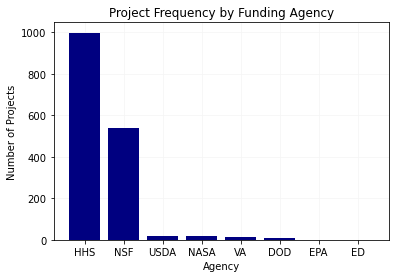

In [38]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
#plt.ylim(0,100)
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency")

#plt.savefig("figures/OECD/agency_dist.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("figures/OECD/agency_dist.pdf", dpi = 800, bbox_inches = "tight")

In [39]:
pd.pivot_table(d_new, values=['PROJECT_ID'], index=['DEPARTMENT'], columns=['label'], aggfunc='count', fill_value=0, margins = True)

PROJECT_ID                   
label        Big-data Non Big-data   All
DEPARTMENT                              
DOD                 2            7     9
ED                  0            1     1
EPA                 0            1     1
HHS               296          702   998
NASA                4           15    19
NSF               378          162   540
USDA                5           15    20
VA                  2           10    12
All               687          913  1600

<AxesSubplot:xlabel='DEPARTMENT', ylabel='count'>

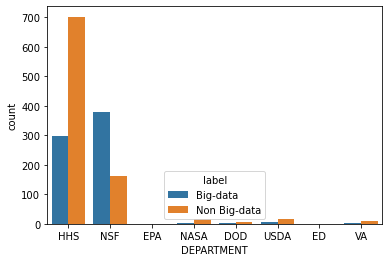

In [40]:
sns.countplot(data=d_new, x='DEPARTMENT', hue='label')

#g.set_axis_labels("", "Body mass (g)")
#g.legend.set_title("")

In [41]:
year_counts = d_new["FY"].value_counts().sort_index(ascending=True)

Text(0.5, 1.0, 'Project Frequency by FY')

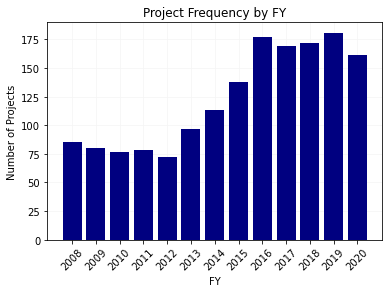

In [42]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
#plt.xlim(-0.7, len(year)-0.3)
#plt.xlim(2007.3,2020.7)
plt.xticks(year, rotation=45)
#ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("FY")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by FY")

#plt.savefig("startyr_freq.png", dpi = 800, bbox_inches = "tight")
#plt.savefig("startyr_freq.pdf", dpi = 800, bbox_inches = "tight")

In [43]:
pd.pivot_table(d_new, values=['PROJECT_ID'], index=['FY'], columns=['label'], aggfunc='count', fill_value=0, margins = True)

PROJECT_ID                   
label   Big-data Non Big-data   All
FY                                 
2008          11           74    85
2009          20           60    80
2010          17           60    77
2011          19           59    78
2012          15           57    72
2013          37           60    97
2014          45           68   113
2015          68           70   138
2016          91           86   177
2017          90           79   169
2018          96           76   172
2019         100           81   181
2020          78           83   161
All          687          913  1600

<AxesSubplot:xlabel='FY', ylabel='count'>

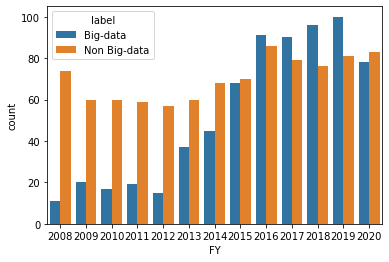

In [44]:
sns.countplot(data=d_new, x='FY', hue='label', order=d["FY"].value_counts().sort_index(ascending=True).index)

##### Compare labels with term matching on "big data"

In [45]:
# cross check training set with term matching for "big data"

d_new["big data term"] = False

In [46]:
d_new.head()

,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label,DEPARTMENT,FY,big data term
0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data,HHS,2017,False
1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data,HHS,2019,False
2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data,HHS,2008,False
3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data,HHS,2016,False
4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data,HHS,2015,False


In [47]:
for idx, abstract in enumerate(d_new['ABSTRACT']):
    if "big data" in abstract.lower() or "big-data" in abstract.lower():
        d_new.iloc[idx, 9] = True

In [48]:
sum(d_new['big data term'])

596

In [49]:
pd.pivot_table(d_new, values=['PROJECT_ID'], index=['big data term'], columns=['label'], aggfunc='count', fill_value=0, margins=True)

PROJECT_ID                   
label           Big-data Non Big-data   All
big data term                              
False                244          760  1004
True                 443          153   596
All                  687          913  1600

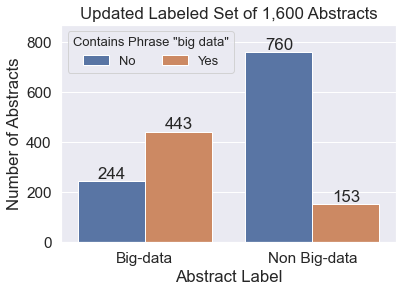

In [126]:
sns.set(font_scale=1.4)
ax = sns.countplot(data=d_new, x='label', hue='big data term')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.12, p.get_height()+10))
plt.ylim(0,870)

plt.title("Updated Labeled Set of 1,600 Abstracts")
plt.xlabel("Abstract Label")
plt.ylabel("Number of Abstracts")
plt.legend(title='Contains Phrase "big data"', loc='upper left', ncol=2, labels=['No', 'Yes'], 
          title_fontsize=13, fontsize=13) #bbox_to_anchor=(0.80, -0.2))

plt.savefig("figures/update_label_term.png", bbox_inches = "tight")